In [5]:
from langgraph.graph import START, END, StateGraph
from langchain_ollama import ChatOllama

In [6]:
from IPython.display import Image, display
from typing_extensions import TypedDict

In [7]:
class State(TypedDict):
    topic: str
    joke: str
    improve_joke: str
    final_joke: str

In [23]:
llm = ChatOllama(model="qwen2.5:7b", base_url="http://localhost:11434")
# Node
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"请写一篇关于{state["topic"]}的笑话。")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"请给这个笑话添加一些歇后语，让其更有趣：{state["joke"]}")
    return {"improve_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"给这个笑话添加一个令人惊讶的转折：{state["improve_joke"]}")
    return {"final_joke": msg.content}

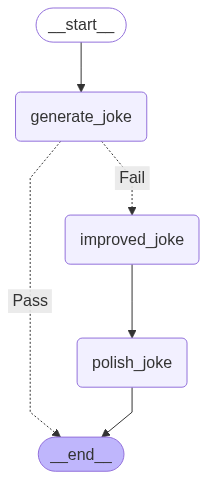

In [24]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("improved_joke", improve_joke)
workflow.add_node("generate_joke", generate_joke)

workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improved_joke", "Pass": END}
)
workflow.add_edge("improved_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

chain = workflow.compile()



display(Image(chain.get_graph().draw_mermaid_png()))



In [25]:
state = chain.invoke({"topic": "猫咪"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
当然可以，下面是一则关于猫咪的小笑话：

有一天，一只猫和它的主人去参加了一个宠物才艺比赛。比赛项目有很多，包括跳舞、走秀、识字等。轮到猫上场了，主持人问它：“你先来展示一下你的特殊才能吧！”

猫轻盈地跳上了舞台中央，然后缓缓伸出了爪子，对准了自己身前的一只小铃铛。

“准备好了吗？”主持人问道。

猫看了一眼铃铛，又看了看主人和观众。然后，它做了个深呼吸，轻轻地挥了挥尾巴。

突然，“喵”地叫了一声，紧接着，那个小铃铛“叮”的一声响了起来！

全场都惊呆了，观众们纷纷鼓掌。这时，猫又对着主持人做了一个可爱的表情，仿佛在说：“看！我还会唱歌呢！”

主持人兴奋地说：“哇哦！你的猫可是个天才啊！不过，我们这次比赛还是以特技为主，请你展示一下吧。”

猫笑了笑，再次伸出了爪子，对准了另一个目标——主人手中的一个小纸条。

“准备好了吗？”主持人问。

猫又看了一眼纸条，然后做出了一个深思熟虑的动作。只见它轻巧地一跳，用前爪抓起了那张纸条。

这时，所有观众的目光都转向了纸条。上面只写了一个字：“鱼”。

全场再次爆发出了热烈的掌声。猫得意洋洋地舔了舔爪子，仿佛在说：“怎么样？谁说猫不会写字？”

--- --- ---

Joke failed quality gate - no punchline detected!
